# Объединённая метрика: `FFT_dF` + `DTCWT_Entropy`

---

### Размышления о постановке задачи.  

Метрика аберрантности (шумности) генома — функция, отображающая вектор, размером 2^14 в скаляр. Из биологических соображений мы можем назвать некоторые регионы генома "очень шумными", некоторые "средне шумными", а некоторые "спокойными". Однако, здесь следует иметь ввиду, что чёткой границы между этими группами регионов не может быть. Более того, значительная часть регионов из группы "очень шумных" может пересекаться с регоионами из группы "спокойных". 

Остюда возникает вопрос — как убедиться в том, что введённая метрика (метрики) достаточно хорошо описывает степень зашумлённости региона?

Во-первых, давайте в качестве референса использовать стандартное отклонение (Std), посчитанное для значений региона. Std уже является примитивной метрикой аберрантности — спокойные регионы меньше содержат выборсов, следовательно, имеют меньшее значение Std.

Во-вторых, давайте предложим способы сравнения между собой несколькоих метрик. Тогда, порождая новые метрики будет легко выбрать оптимальную.

### Cпособы сравнения метрик

Для всего множества регионов всех семи геномов датасета GIAB ранее было предложено каскадное разбиение, согласно которому каждый регион попадал в одно из пяти множеств: V0_bad, V1_bad, V2_bad, V3_bad, V3_good. Теперь можно продолжить эту идею, отранжировав регионы внутри каждой группы. Ранжирование проведём по тому параметру, по которому сформирована группа. Например, V0_bad получаются по числу покрытых баз. Давайте для каждого региона из V0_bad посчитаем долю покрытых баз — чем больше эта доля, тем лучше регион (внутри данной группы). Для регионов V0_bad отводим диапазон значений `[0-1]`. Аналогично, для регионов V1_bad используется процент пересечения со "сложными регионами генома" (all_diff), для этих регионов отводится диапазон значений `[1-2]` и получается он так: к проценту пересечения региона с all_diff прибавляется единица. Формулы:

In [5]:
def get_range(row):
    if row['acent'] > 0 or row['covered_bases'] < 1: # V0 bad [0-1]
        return 0 + row['covered_bases']
    if row['all_diff'] > 0.8:                        # V1 bad [1-2]
        return 1 + (1 - row['all_diff']) / (1-0.8)
    if row['lc_vcf'] > 0:                            # V2 bad [2-3]
        return 2 + (1 - row['lc_vcf'])
    if row['hc_vcf'] > 0.1:                          # V3 bad [3-4]
        return 3 + (1 - row['hc_vcf']) / (1-0.1)
    return 4 + row['hc_vcf'] / 0.1                   # V3 good [4-5]

Теперь для каждого региона есть зачение от 0 до 5, полученное не только из данных покрытия но и из косвенных источников (vcf, all difficult regions). Формально, любые вводимые метрики должны справляться с задачей классификации регионов не хуже, чем референсная метрика Std. При этом не следует оценивать классификатор "напрямую", т.к. вводимые нами классы V0-V3 обладают большим взаимным перекрытием и качественная классифивация в них заведомо невозможна.

**Способ оценки метрки 1**: Используя ранжирование внутри каждой из групп `Vi` мы можем отсортировать все регионы от "самого спокойного" до "самого шумного", извлечь соответствующие такому прядку значения интересующей нас метрики и посчитать количество перестановок внутри этих значений. Если введённая метрика хороша и соответствует биологии, то значения этой метрики в самом лучшем случае будут непрерывно возрастать от "спокойных" к "шумным" регионам.

In [11]:
# Перед запуском выполнить код в конце ноутбука
std_ref = invc(LB['Std'].tolist())
print(f"Std [ref]: {std_ref:.2f}")
for m in ['DWT_n', 'FFT_dF_n', 'DTCWT_n', 'LC', 'matrix']:
    pc = std_ref/invc(LB[m].tolist()) - 1
    print(f"{m:<10} {pc:.1%}")

NameError: name 'invc' is not defined

Пояснения к числам:  `Std [ref]: 0.44` означает, что `44%` значений метрики `Std` "стоят" не на своих местах. Три следующие числа показывают отношение перемешанности массива значений метрики к рефересну `0.44`. Например, `DWT_n` вводит для регионов отношение порядка, которое на `9.4%` хуже, чем то, что вводится `Std`. `DTCWT_n`, наоборот, выстраивает значения метрик в порядке, на `34.5%` ближе к эталонному (введённому ранжированием регионов), чем `Std`

**Способ оценки метрки 2**: После введения метрики мы планируем использовать её как бинарный классификатор с одним порогом (например, так: при значениях меньше `t` регион спокойный, при значениях больше `t` — шумный). Для оценки метрики можно существенно усложнить задачу классификации, оценивая классификатор отдельно внутри каждой группы каскада регионов (`V0-V3`) и найдя среднее. Здесь стоит снова обратить внимание на постановку задачи классификации. Регионы, которые попадают в соседние группы каскада практически неотличимы друг от друга по сигналу покрытия. Фактически, отличия `V3_good` от `V3_bad` минимальны, не заметны глазом, а то и вовсе могут отсутствовать. Поэтому любое значение качества классификатора, отличное от 50% нас устроит. Будем смотреть, во сколько раз качество введённого классификатора больше, чем кечество `Std` как классификатора.

Описание оценки метрики: внутри каждой группы `Vi` считаем занчения метрики для `Vi_good` и `Vi_bad`, подбираем значения порога так, чтобы метрика для максимальной доля регионов из `Vi_good` оказалась больше этого порга, а для регионов из `Vi_bad` — меньше. Считаем accuracy как `0.5 * TP / P + 0.5 * TN / N` что равносильно `(TPR + TNR) / 2`. Сравниваем это значение (отдельно для каждого уровня `Vi`) с аналогичной оценкой для `Std`. Усредняем значения по всем уровням. Формулы:

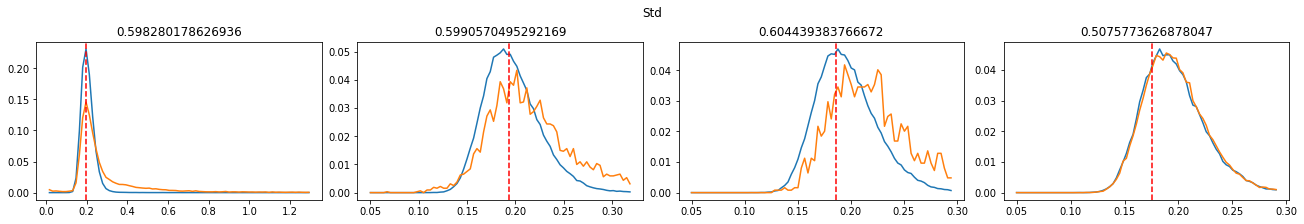

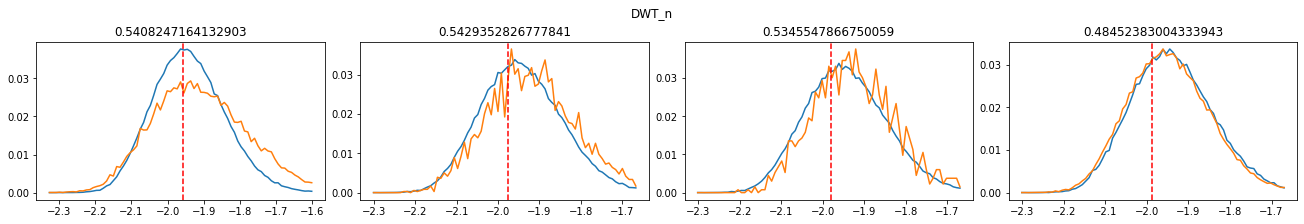

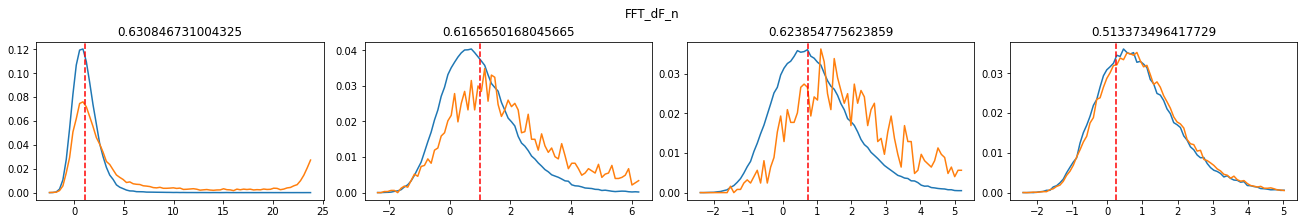

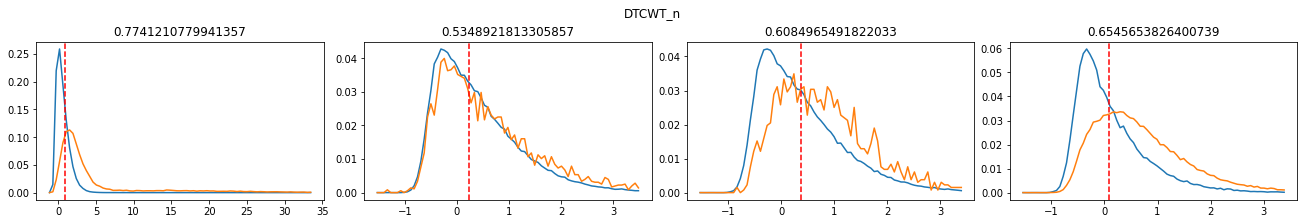

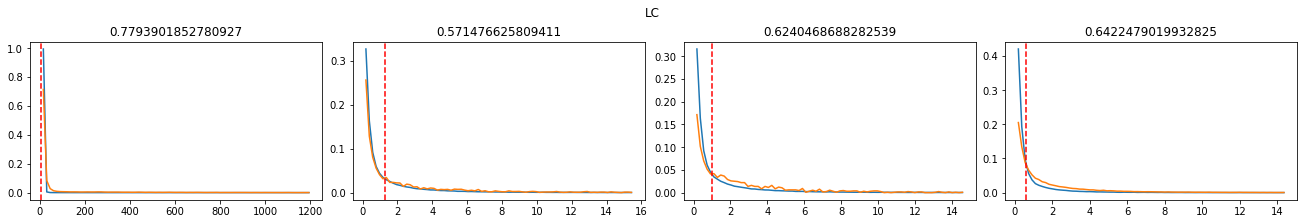

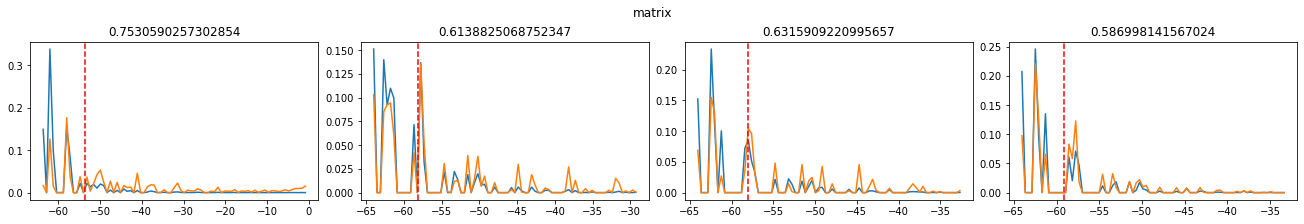

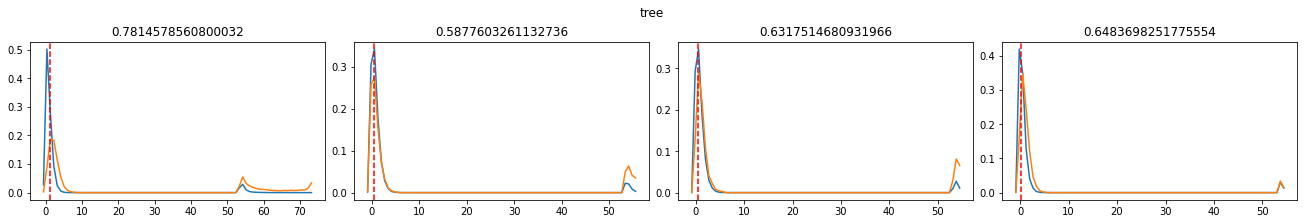

In [59]:
names = ['Std', 'DWT_n', 'FFT_dF_n', 'DTCWT_n', 'LC', 'matrix', 'tree']
df = pd.DataFrame({m:fnmax(m) for m in names})
# df

In [45]:
for m in names:
    if m == 'Std': continue
    pc = (df[m]/df['Std'] - 1).mean()
    print(f"{m:<10} {pc:.1%}")

DWT_n      -8.8%
FFT_dF_n   3.2%
DTCWT_n    12.1%
LC         13.9%
matrix     12.1%
tree       12.1%


---

Инициализировать перед основным кодом:

In [1]:
def mergeSort(arr, n):
    temp_arr = [0]*n
    return _mergeSort(arr, temp_arr, 0, n-1)
  

def _mergeSort(arr, temp_arr, left, right):
    inv_count = 0
    if left < right:
        mid = (left + right)/2
        inv_count += _mergeSort(arr, temp_arr,
                                left, mid)
        inv_count += _mergeSort(arr, temp_arr,
                                mid + 1, right)
        inv_count += merge(arr, temp_arr, left, mid, right)
    return inv_count

def merge(arr, temp_arr, left, mid, right):
    i = left     # Starting index of left subarray
    j = mid + 1  # Starting index of right subarray
    k = left     # Starting index of to be sorted subarray
    inv_count = 0
    while i <= mid and j <= right:
        if arr[i] <= arr[j]:
            temp_arr[k] = arr[i]
            k += 1
            i += 1
        else:
            temp_arr[k] = arr[j]
            inv_count += (mid-i + 1)
            k += 1
            j += 1
    while i <= mid:
        temp_arr[k] = arr[i]
        k += 1
        i += 1
    while j <= right:
        temp_arr[k] = arr[j]
        k += 1
        j += 1
    for loop_var in range(left, right + 1):
        arr[loop_var] = temp_arr[loop_var]
    return inv_count
# https://www.geeksforgeeks.org/counting-inversions/

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


with open('_matrix.n1b.json', 'r') as f:
    mat, xar, yar = [np.array(e) for e in json.load(f)]

# Globals: mat, xar, yar
def m_index(obj, v):
    if obj[0]  > v: return -2
    if obj[-1] < v: return -1
    return np.where(obj <= v)[0][-1]

def matrix(x, y):
    i, j = (m_index(xar, x), m_index(yar, y))
    if i == -2 or j == -2: return np.max(mat)
    if i == -1 or j == -1: return np.min(mat)
    return mat[i][j]  

In [6]:
def load_sample(name):
    dt = pd.read_csv(f'../../data/GIAB/_las_noappr/{name}_p14.lasbed', sep=' ')
    dt['Sample'] = name
    return dt

hg = [1,2,3,4] # 
hg = [1,2,3,4,5,6,7]
LB = pd.concat([load_sample(f'HG00{i}') for i in hg])
LB = LB[LB['covered_bases'] > 0]

# Normalize
fft_m, fft_s = (1783.7347186000002, 263.58889402976223)
dtt_m, dtt_s = (9.111856, 0.06325841730085836)
LB['FFT_dF_n'] = (LB['FFT_dF'] - fft_m)/fft_s
LB['DTCWT_n'] = -(LB['DTCWT_Entropy'] - dtt_m)/dtt_s
LB['DWT_n'] = -LB['DWT_Energy_Entropy']

# Matrix
nor7d = np.transpose([LB['FFT_dF_n'], LB['DTCWT_n']])
LB['matrix'] = [-matrix(x_, y_) for x_, y_ in nor7d]

# Linear combination
(dx, dy, scale) = (-1.232, 0.324, 0.072)
LB['LC'] = scale * (LB['FFT_dF_n'] + dx)**2 + (LB['DTCWT_n'] + dy)**2

# Range
LB['R'] = LB.apply(get_range, axis = 1)

# Sort
LB = LB.sort_values(by=['R'], ascending=False)

In [7]:
# LB.to_csv('../../data/GIAB/_df.1-7.csv')

In [8]:
inv_norm = mergeSort(len(LB) - np.arange(len(LB)), len(LB))
invc = lambda x: mergeSort(x, len(x))/inv_norm

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
def separate(T):
    V = [{
      'good': T.loc[(T['covered_bases'] == 1) & (T['acent'] == 0)],
      'bad':  T.loc[(T['covered_bases'] < 1) | (T['acent'] > 0)]
    }]
    V.append({
      'good': V[0]['good'][V[0]['good']['all_diff'] <= 0.8],
      'bad':  V[0]['good'][V[0]['good']['all_diff'] > 0.8]
    })
    V.append({
      'good': V[1]['good'][V[1]['good']['lc_vcf'] == 0],
      'bad':  V[1]['good'][V[1]['good']['lc_vcf'] > 0]
    })
    V.append({
      'good': V[2]['good'][V[2]['good']['hc_vcf'] <= 0.1],
      'bad':  V[2]['good'][V[2]['good']['hc_vcf'] > 0.1]
    })
    return V

LBS = separate(LB)

In [18]:
def _csv(src, name):
    src.filter(items=[
        'Std', 'FFT_dF_n', 'DTCWT_n', 'matrix', 'LC', 'Sample'
    ]).to_csv(f'../../data/GIAB/_{name}.csv')

labels = ['L0_bad', 'L1_bad', 'L2_bad', 'L3_bad', 'L3_good']
for i in range(4):
    _csv(LBS[i]['bad'], labels[i])
_csv(LBS[3]['good'], labels[4])

In [8]:
def hists(A, B):
    l, r = (min(A + B), np.quantile(A + B, 0.995))
    X = np.arange(l, r, (r-l)/80)
    return (np.histogram(A, bins=X)[0], np.histogram(B, bins=X)[0], X)


def tprfpr(A, B):
    dt = np.array([[v, 1] for v in A] + [[v, 0] for v in B])
    dt = dt[dt[:, 0].argsort()]
    tpr = np.cumsum(dt[:, 1])/np.sum(dt[:, 1])
    fpr = np.cumsum(1 - dt[:, 1])/(len(dt) - np.sum(dt[:, 1]))
    return (tpr, fpr, dt)


def acc(A, B, At, Bt):
    tpr, fpr, dt = tprfpr(A, B)
    dst = [(x**2 + (1-y)**2) for x,y in np.transpose([fpr, tpr])]
    t_ = dt[np.argmin(dst)][0]
    At, Bt = (np.array(At), np.array(Bt))
    acc_ = 0.5 * (len(At[At < t_])/len(At) + len(Bt[Bt >= t_])/len(Bt))
    return (acc_, t_)

def getset(i, name):
    A, B = (LBS[i]['good'], LBS[i]['bad'])
    return (
        A[A['Sample'] != 'HG002'][name].tolist(),
        B[B['Sample'] != 'HG002'][name].tolist(),
        A[A['Sample'] == 'HG002'][name].tolist(),
        B[B['Sample'] == 'HG002'][name].tolist(),
    )

def fnmax(name):
    accs = []
    axs = plt.figure(figsize=(18, 3), constrained_layout=True).subplots(1, 4)
    for i in range(4):
        A, B, At, Bt = getset(i, name)
        ha, hb, xx = hists(At, Bt)
        axs[i].plot(xx[1:], ha/ha.sum())
        axs[i].plot(xx[1:], hb/hb.sum())
        (acc_, t_) = acc(A, B, At, Bt)
        axs[i].axvline(x=t_, color='red', linestyle='--')
        axs[i].set_title(acc_)
        accs.append(acc_)
    plt.suptitle(f'{name}')
    plt.show()
    return accs

In [43]:
from IPython.display import display, Javascript, HTML
import json 

display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="d3/hists.js"))
display(HTML(filename="d3/style.html"))

def hs(obj):
    v, x = np.histogram(obj, bins=200)
    return {'y': (v/v.sum()).tolist(), 'x': x.tolist()}

def hists(data):
    display(Javascript("""
        (function(e){ require(['hists'], function(fn) { fn(e.get(0), %s); }); })(element);
    """ % (json.dumps(data))))

def allHists(by, lim=None):
    P = {}
    for i in range(4):
        if lim == None:
            t = LBS[i]['bad'][by]
        else:
            t = LBS[i]['bad'].loc[(LBS[i]['bad'][by] < lim[1]) & (LBS[i]['bad'][by] > lim[0])][by]
        P[f"V{i} bad"] = hs(t)
    if lim == None:
        t = LBS[i]['good'][by]
    else:
        t = LBS[i]['good'].loc[(LBS[i]['good'][by] < lim[1]) & (LBS[i]['good'][by] > lim[0])][by]
    P[f"V{i} good"] = hs(t)
    hists(P)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
print("DTCWT_n")
allHists('DTCWT_n', (-3, 9))
print("FFT_dF_n")
allHists('FFT_dF_n')
print("matrix")
allHists('matrix')
print("LC")
allHists('LC',(-5, 10))
print("Tree")
allHists('tree')

DTCWT_n


<IPython.core.display.Javascript object>

FFT_dF_n


<IPython.core.display.Javascript object>

matrix


<IPython.core.display.Javascript object>

LC


<IPython.core.display.Javascript object>

Tree


<IPython.core.display.Javascript object>